In [2]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.utils.data import Dataset
from pyproj import CRS
import pandas as pd
import torch
import lightning as L
from torchvision import transforms
import xarray as xr
import torch
import torch.nn as nn
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from sklearn.model_selection import train_test_split
from lightning.pytorch import seed_everything
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import warnings
import os

warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('high')
seed_everything(42, workers=True)

Seed set to 42


42

## 

In [3]:
class SuperResolutionModel(L.LightningModule):
    def __init__(self, model):

        super().__init__()
        self.lr = 1e-3
        self.model = model
        self.psnr = PeakSignalNoiseRatio()
        self.ssim = StructuralSimilarityIndexMeasure()

    def forward(self, x):
        upscaled_img = self.model(x)
        return upscaled_img

    def training_step(self, batch, batch_idx):

        lr_img, hr_img = batch
        sr_img = self(lr_img)

        loss = nn.functional.mse_loss(sr_img, hr_img)
        psnr_value = self.psnr(sr_img, hr_img)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_psnr', psnr_value, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        lr_img, hr_img = batch
        sr_img = self(lr_img)
        loss = nn.functional.mse_loss(sr_img, hr_img)
        psnr_value = self.psnr(sr_img, hr_img)
        ssim_value = self.ssim(sr_img, hr_img)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_psnr', psnr_value, prog_bar=True)
        self.log('val_ssim', ssim_value, prog_bar=True)

        # Log images to TensorBoard every 10 steps
        if batch_idx % 10 == 0:
            self.log_images(lr_img, hr_img, sr_img, self.current_epoch)  # Make sure batch_idx is passed here

        return {'val_loss': loss, 'val_psnr': psnr_value, 'val_ssim': ssim_value}

    def test_step(self, batch, batch_idx):
        lr_img, hr_img = batch
        sr_img = self(lr_img)

        loss = nn.functional.mse_loss(sr_img, hr_img)
        psnr_value = self.psnr(sr_img, hr_img)
        ssim_value = self.ssim(sr_img, hr_img)

        self.log('test_loss', loss, prog_bar=True)
        self.log('test_psnr', psnr_value, prog_bar=True)
        self.log('test_ssim', ssim_value, prog_bar=True)

        return {'test_loss': loss, 'test_psnr': psnr_value, 'test_ssim': ssim_value}

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer


    def log_images(self, lr_img, hr_img, sr_img, epoch):
        """
        Helper function to log input, target, and output images to TensorBoard, including cartopy plots
        """
        # Ensure images are in range [0, 1]
        lr_img = lr_img.cpu()
        hr_img = hr_img.cpu()
        sr_img = sr_img.cpu()

        # Convert lr_img, hr_img to numpy for cartopy visualization
        lr_img_np = lr_img.squeeze().numpy()[0]  # (lat, lon) format
        hr_img_np = hr_img.squeeze().numpy()[0] # (lat, lon) format
        sr_img_np = sr_img.squeeze().numpy()[0] # (lat, lon) format

        lon_min, lon_max = 5, 16.25
        lat_min, lat_max = 47, 58.22

        # Create a single figure with two subplots (for HR and LR)
        fig, ax = plt.subplots(1, 3, figsize=(12, 6), subplot_kw={'projection': ccrs.Mercator()})
        # Plot high-resolution data
        ax[0].coastlines()
        ax[0].add_feature(cf.BORDERS)
        ax[0].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax[0].imshow(lr_img_np, origin='upper', extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree(), cmap="YlOrRd")
        ax[0].set_title("Low-Resolution")
        # Plot low-resolution data
        ax[1].coastlines()
        ax[1].add_feature(cf.BORDERS)
        ax[1].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax[1].imshow(hr_img_np, origin='upper', extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree(), cmap="YlOrRd")
        ax[1].set_title("High-Resolution")

        ax[2].coastlines()
        ax[2].add_feature(cf.BORDERS)
        ax[2].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax[2].imshow(sr_img_np, origin='upper', extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree(), cmap="YlOrRd")
        ax[2].set_title("High-Resolution Prediction")
        # Adjust layout for better spacing
        plt.tight_layout()
        # Get the current logging directory (e.g., lightning_logs/version_0)
        log_dir = self.logger.log_dir
        # Save the figure to a PNG file with the format: {stage}_epoch{epoch}_batch{batch_idx}.png
        save_dir = os.path.join(log_dir, 'val_prediction')
        os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
        plt.savefig(f"{save_dir}/epoch_{str(epoch)}.png", format='png', bbox_inches='tight')
        plt.close(fig)

In [30]:
# %%capture cap
# %run ./cacheb-authentication.py

In [31]:
# output_1 = cap.stdout.split('}\n')
# token = output_1[-1][0:-1]

# from pathlib import Path
# with open(Path.home() / ".netrc", "a") as fp:
#     fp.write(token)

In [32]:
def compute_mean_std(data):
    """
    Computes the mean and standard deviation of the entire xarray dataset.
    Args:
        data (xarray.DataArray): Dataset (either HR or LR) to compute stats for
    Returns:
        mean (float), std (float): The mean and standard deviation of the dataset
    """
    mean = data.mean().values
    std = data.std().values
    return np.float64(mean), np.float64(std)

In [61]:
data = xr.open_dataset(
        "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-standard-sfc-v0.zarr",
        engine="zarr",
        storage_options={"client_kwargs": {"trust_env": "true"}},
        chunks={},
    )
t2m_lr = data.t2m.astype("float32") - 273.15
t2m_lr.attrs["units"] = "C"
lr = t2m_lr.sel(**{"latitude": slice(47, 58.22), "longitude": slice(5, 16.25)})
lr = lr.sel(time="2024")
lr

<xarray.DataArray 't2m' (time: 8784, latitude: 32, longitude: 32)> Size: 36MB
dask.array<getitem, shape=(8784, 32, 32), dtype=float32, chunksize=(576, 32, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 256B 47.03 47.38 47.73 ... 57.24 57.59 57.95
  * longitude  (longitude) float64 256B 5.273 5.625 5.977 ... 15.47 15.82 16.17
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23:00:00
Attributes:
    units:    C

In [62]:
data = xr.open_dataset(
        "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr",
        engine="zarr",
        storage_options={"client_kwargs": {"trust_env": "true"}},
        chunks={},
    )
t2m_hr = data.t2m.astype("float32") - 273.15
t2m_hr.attrs["units"] = "C"
hr = t2m_hr.sel(**{"latitude": slice(47, 58.22), "longitude": slice(5, 16.25)})
hr = hr.sel(time="2024")

In [63]:
hr

<xarray.DataArray 't2m' (time: 8784, latitude: 256, longitude: 256)> Size: 2GB
dask.array<getitem, shape=(8784, 256, 256), dtype=float32, chunksize=(48, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 2kB 47.01 47.05 47.1 ... 58.13 58.18 58.22
  * longitude  (longitude) float64 2kB 5.01 5.054 5.098 ... 16.13 16.17 16.22
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 70kB 2024-01-01 ... 2024-12-31T23:00:00
Attributes:
    units:    C

Text(0.5, 1.0, 'High-Resolution')

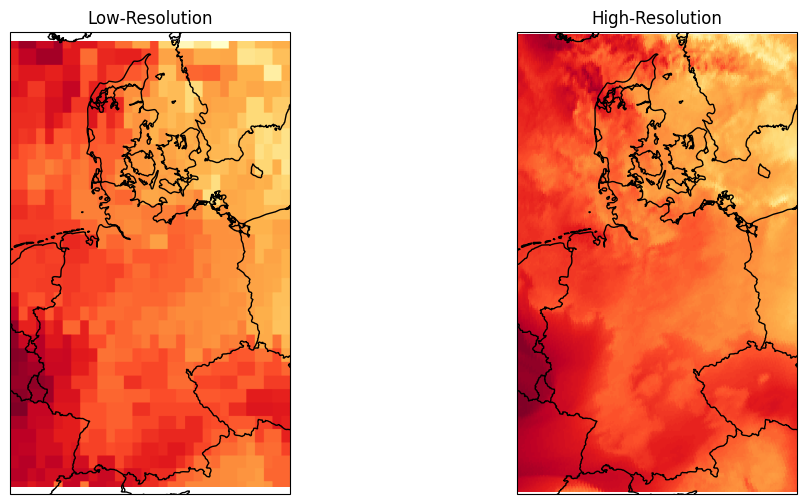

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': ccrs.Mercator()})
# Define the area of interest
lon_min, lon_max = 5, 16.25
lat_min, lat_max = 47, 58.22
# Plot high-resolution data
ax[0].coastlines()
ax[0].add_feature(cf.BORDERS)
ax[0].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax[0].imshow(lr[0].values, origin='upper', extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree(), cmap="YlOrRd")
ax[0].set_title("Low-Resolution")

# Plot low-resolution data
ax[1].coastlines()
ax[1].add_feature(cf.BORDERS)
ax[1].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax[1].imshow(hr[0].values, origin='upper', extent=[lon_min, lon_max, lat_min, lat_max], transform=ccrs.PlateCarree(), cmap="YlOrRd")
ax[1].set_title("High-Resolution")

In [65]:
scale_factor_latitude = hr[0].shape[0] /lr[0].shape[0]
scale_factor_longitude = hr[0].shape[1] /lr[0].shape[1]
print(f"scaling factor latitude: {scale_factor_latitude}")
print(f"scaling factor longitude: {scale_factor_longitude}")

scaling factor latitude: 8.0
scaling factor longitude: 8.0


## Generate dataset

In [66]:
hr_mean, hr_std = compute_mean_std(hr)
lr_mean, lr_std = compute_mean_std(lr)
print(f"hr_mean: {hr_mean},hr_std {hr_std}")
print(f"lr_mean: {lr_mean},lr_std {lr_std}")

hr_mean: 8.03427791595459,hr_std 8.384730339050293
lr_mean: 7.959541320800781,lr_std 8.439879417419434


In [67]:
class CreateDataset(Dataset):
    def __init__(self, hr_data, lr_data, hr_mean, hr_std, lr_mean, lr_std, batch_size):
        """
        Args:
            hr_data (xarray.DataArray): High-resolution data
            lr_data (xarray.DataArray): Low-resolution data
            hr_mean, hr_std: mean and std for HR data normalization
            lr_mean, lr_std: mean and std for LR data normalization
            batch_size: the size of the batch to download at once
        """
        self.hr_data = hr_data
        self.lr_data = lr_data
        self.hr_mean, self.hr_std = hr_mean, hr_std
        self.lr_mean, self.lr_std = lr_mean, lr_std
        self.batch_size = batch_size

        # Define the transformations for high-resolution and low-resolution data
        self.hr_transform = transforms.Normalize(mean=[hr_mean], std=[hr_std])
        self.lr_transform = transforms.Normalize(mean=[lr_mean], std=[lr_std])

        # Calculate the number of batches
        self.num_batches = int(np.ceil(len(self.hr_data.time) / batch_size))

    def __len__(self):
        # Dataset length is the number of batches
        return self.num_batches

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the batch to return
        Returns:
            tuple: (low-resolution, high-resolution) data as tensors
        """
        if idx >= self.num_batches:
            raise IndexError("Index out of bounds")

        # Select a batch of time slices instead of a single time slice
        batch_start = idx * self.batch_size
        batch_end = min(batch_start + self.batch_size, len(self.hr_data.time))

        # Download a batch of HR and LR data
        hr_batch = self.hr_data[batch_start:batch_end].load().values
        lr_batch = self.lr_data[batch_start:batch_end].load().values

        # Convert to torch tensors and reshape to match (N, H, W) format
        hr_batch = torch.tensor(hr_batch, dtype=torch.float32).unsqueeze(1)
        lr_batch = torch.tensor(lr_batch, dtype=torch.float32).unsqueeze(1)

        # Apply normalization transforms
        hr_batch = self.hr_transform(hr_batch)
        lr_batch = self.lr_transform(lr_batch)

        return lr_batch, hr_batch

In [68]:
# Splitting dataset indices using sklearn's `train_test_split`
time_indices = np.arange(len(hr.time.values))

# Split into train and remaining (validation + test)
train_indices, remaining_indices = train_test_split(time_indices, train_size=0.7, shuffle=True, random_state=42)

# Split remaining into validation and test sets
val_indices, test_indices = train_test_split(remaining_indices, test_size=0.2, shuffle=True, random_state=42)

# Select corresponding data slices
train_hr = hr.isel(time=train_indices)
val_hr = hr.isel(time=val_indices)
test_hr = hr.isel(time=test_indices)

train_lr = lr.isel(time=train_indices)
val_lr = lr.isel(time=val_indices)
test_lr = lr.isel(time=test_indices)

print(f"Train samples: {len(train_hr.time.values)}")
print(f"Validation samples: {len(val_hr.time.values)}")
print(f"Test samples: {len(test_hr.time.values)}")

Train samples: 6148
Validation samples: 2108
Test samples: 528


In [69]:
# Define batch size
batch_size = 64

train_loader = CreateDataset(hr_data=train_hr, lr_data=train_lr,
                              hr_mean=hr_mean, hr_std=hr_std,
                              lr_mean=lr_mean, lr_std=lr_std,
                              batch_size=batch_size)


val_loader = CreateDataset(hr_data=val_hr, lr_data=val_lr,
                             hr_mean=hr_mean, hr_std=hr_std,
                              lr_mean=lr_mean, lr_std=lr_std,
                              batch_size=batch_size)

# Create test dataset
test_loader = CreateDataset(hr_data=test_hr, lr_data=test_lr,
                             hr_mean=hr_mean, hr_std=hr_std,
                             lr_mean=lr_mean, lr_std=lr_std,
                             batch_size=batch_size)

In [70]:
from lightning.pytorch.callbacks import ModelCheckpoint
from model import SRResNet

sr_model = SRResNet(large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=8)

# Instantiate the LightningModule (SuperResolutionModel)
model = SuperResolutionModel(sr_model)

# Define the model checkpoint callback
checkpoint_val_ssim = ModelCheckpoint(
    monitor="val_ssim",         # Metric to monitor (e.g., 'val_loss')
    filename="best-val-ssim-{epoch:02d}-{val_ssim:.2f}",  # Filename template
    save_top_k=1,               # Save only the best model (by val_loss)
    mode="max"                  # 'min' because we want to minimize validation loss
)
# Set up the Trainer with the checkpoint callback
trainer = L.Trainer(
    devices=[0],  # specify GPU devices
    max_epochs=100,
    accelerator="gpu",
    deterministic=True,
    callbacks=[checkpoint_val_ssim],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [59]:
# Start training
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                              | Params | Mode 
--------------------------------------------------------------------
0 | model | SRResNet                          | 1.7 M  | train
1 | psnr  | _PeakSignalNoiseRatio             | 0      | train
2 | ssim  | _StructuralSimilarityIndexMeasure | 0      | train
--------------------------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.706     Total estimated model params size (MB)
189       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [22]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.0551811456680298     │
│         test_psnr         │    18.138134002685547     │
│         test_ssim         │    0.07095132023096085    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.0551811456680298,
  'test_psnr': 18.138134002685547,
  'test_ssim': 0.07095132023096085}]

In [47]:
def save_best_model_as_pt(checkpoint_callback, model_class, model_instance):
    """
    Saves the best checkpoint as a standard PyTorch .pth file.

    Args:
        checkpoint_callback (ModelCheckpoint): The checkpoint callback used during training.
        model_class (LightningModule subclass): The Lightning model class.
        model_instance (nn.Module): The PyTorch model instance.
    """
    # Get the path to the best checkpoint
    best_checkpoint_path = checkpoint_callback.best_model_path
    print(f"Best checkpoint path: {best_checkpoint_path}")

    # Load the best checkpoint
    lit_model = model_class.load_from_checkpoint(best_checkpoint_path, model=model_instance)

    # Save the PyTorch model state_dict as .pth
    pth_file_path = best_checkpoint_path.replace("ckpt", "pt")
    torch.save(lit_model.model.state_dict(), pth_file_path)
    print(f"Best model saved as: {pth_file_path}")

In [48]:
save_best_model_as_pt(checkpoint_val_ssim, SuperResolutionModel, sr_model)

Best checkpoint path: /home/ubuntu/project/DestinE_eXchange_SR/lightning_logs/version_10/checkpoints/best-val-ssim-epoch=91-val_ssim=0.43.ckpt
Best model saved as: /home/ubuntu/project/DestinE_eXchange_SR/lightning_logs/version_10/checkpoints/best-val-ssim-epoch=91-val_ssim=0.43.pt


In [49]:
from utils import create_gif_from_images
create_gif_from_images(trainer=trainer)

GIF saved at /home/ubuntu/project/DestinE_eXchange_SR/lightning_logs/version_10/val_prediction/training_progress.gif


In [50]:
from super_resolution_inference import SuperResolutionInference

2024-10-03 13:14:42.574 | INFO     | super_resolution_inference:load_model:33 - Loading checkpoint from /home/ubuntu/project/DestinE_eXchange_SR/lightning_logs/version_10/checkpoints/best-val-ssim-epoch=91-val_ssim=0.43.pt
2024-10-03 13:14:42.597 | INFO     | super_resolution_inference:__init__:20 - Model loaded and moved to device: cuda
2024-10-03 13:14:42.599 | INFO     | super_resolution_inference:preprocess:60 - Preprocessing data with mean=16.192955017089844, std=4.557614326477051


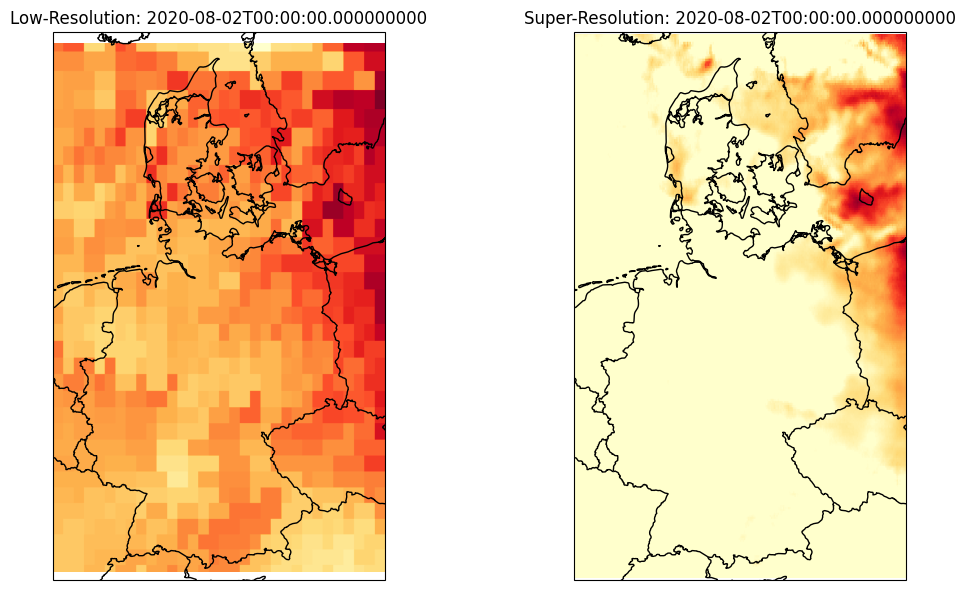

In [57]:
model_path = "/home/ubuntu/project/DestinE_eXchange_SR/lightning_logs/version_10/checkpoints/best-val-ssim-epoch=91-val_ssim=0.43.pt"
model = SRResNet(large_kernel_size=9, small_kernel_size=3, n_channels=64, n_blocks=16, scaling_factor=8)
# Initiaize the inference class
sr = SuperResolutionInference(model_path=model_path, model_class=model)
# Preprocess a single LR image
lr_image = lr[24]  # xarray object
preprocessed_image = sr.preprocess(lr_image, lr_mean=lr_mean, lr_std=lr_std)
# Perform inference
sr_result = sr.inference(preprocessed_image)
# Visualize the LR and SR images
sr.visualize(lr_image=lr_image, sr_image=sr_result, lr_time=lr_image.time.values)

In [6]:
import torch
import torch.nn as nn
import timm
from torchvision.transforms import Resize

# Define the Vision Transformer-based super-resolution model
class ViT_SR(nn.Module):
    def __init__(self, vit_model_name="vit_base_patch16_224", upscale_factor=8, pretrained=True):
        super(ViT_SR, self).__init__()

        # Load a pretrained ViT model from timm
        self.vit = timm.create_model(vit_model_name, pretrained=pretrained, num_classes=768)




    def forward(self, x):
        # Pass the input through the Vision Transformer
        vit_features = self.vit(x)


        return vit_features

# Initialize model
vit_sr_model = ViT_SR(upscale_factor=8)


In [7]:
x = torch.rand(1,3,224,224)

out = vit_sr_model(x)

In [8]:
out.shape

torch.Size([1, 768])